# Fake News Detection




In [1]:
!pip install -U -q PyDrive
!pip install keras==2.11.0
!pip install tensorflow==2.11.0
!pip install catboost
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 27.9 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires keras<2.10.0,>=2.9.0rc0, but you have keras 2.11.0 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 KB 33.7 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing inst

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.stem import PorterStemmer
import re
import optuna
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice
from optuna.trial import TrialState
from optuna.pruners import SuccessiveHalvingPruner
from optuna.samplers import TPESampler
import tensorflow
from tensorflow.keras.layers import Embedding, Dense, LSTM, GRU
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from keras.optimizers import SGD, RMSprop, Adam, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from sklearn.metrics import classification_report,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns

In [23]:
## test dataset
test_data = pd.read_csv('test.csv')

In [24]:
## train dataset
df = pd.read_csv('train.csv')

In [25]:
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [26]:
df["merged"] = df["title"]+" "+df["author"]

In [27]:
df.head()

,id,title,author,text,label,merged
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Why the Truth Might Get You Fired Consortiumne...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,15 Civilians Killed In Single US Airstrike Hav...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Iranian woman jailed for fictional unpublished...


## Basic Analysis

In [28]:
## Check the Null Values 
df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
merged    2515
dtype: int64

As you can see there are some **Null Values**. Drop all these Null values because we can not add word by us randomly.

In [29]:
# Drop Null values
df = df.dropna()

In [30]:
# counting the Unique values to check if the data is balanced or not
count = np.unique(df['label'], return_counts=True)
count

(array([0, 1]), array([10361,  7924]))

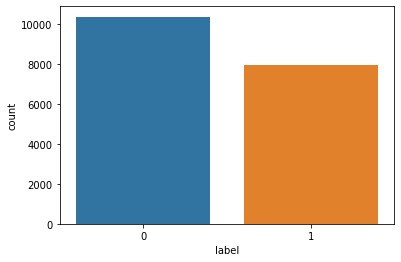

In [31]:
sns.countplot(x='label', data = df)

Conclusion: the data is balanced

**Splitting the dataset into Dependent and Independent Features**

In [32]:
# Dependent Features
Y = df['label']

# Independent Features
X = df.drop('label', axis=1)

## One Hot Representation

changing the dataset into Numerical representation

In [33]:
# making the copy of Dependent Featues and reseting the index because of dropping the nan values due to this 
# the index is disturb
messages = X.copy()
# messages.reset_index(inplace=True)


In [34]:
messages['title'][1]

'FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart'

In [35]:
messages.reset_index(inplace=True)

**Data Preprocessing**

In [36]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [37]:
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

In [38]:
ps = PorterStemmer()
corpus = []
for i in range(0, len(messages)):
    review = re.sub('[^a-zA-Z]', ' ', messages['merged'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords]
    review = ' '.join(review)
    corpus.append(review)

In [39]:
corpus[1]

'flynn hillari clinton big woman campu breitbart daniel j flynn'

In [40]:
voc_size = 5000
onehot_repre = [one_hot(words, voc_size) for words in corpus]
onehot_repre[0]

[4643, 2797, 1425, 2411, 3477, 4008, 2083, 2231, 1368, 2140, 271, 3901]

As it can be seen the data was steammed and changed into numerical representation

## Word Embedding

In [41]:
sent_length = 20
embedded_docs = pad_sequences(onehot_repre, padding='pre', maxlen=sent_length)
print(embedded_docs[0])

[   0    0    0    0    0    0    0    0 4643 2797 1425 2411 3477 4008
 2083 2231 1368 2140  271 3901]


**In above cell every sentence is changed into 20 words, if the sentence is less then 20 words then zeros are added at the start.**

## Creating a Model

In [42]:
embedding_vector_features = 40
model = Sequential()
model.add(Embedding(voc_size, embedding_vector_features, input_length=sent_length))
model.add(LSTM(100))
model.add(Dense(1, activation='relu'))
model.compile(loss='hinge', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 40)            200000    
                                                                 
 lstm (LSTM)                 (None, 100)               56400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________
None


In [43]:
x_final = np.array(embedded_docs)
y_final = np.array(Y)

In [44]:
x_final.shape, y_final.shape

((18285, 20), (18285,))

### Split the Data into Train and Test

In [45]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_final, y_final, test_size=0.1, random_state=42)

### Model Training

In [46]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=90, batch_size=32)

Epoch 1/90
515/515 [==============================] - 17s 26ms/step - loss: 0.6276 - accuracy: 0.9478 - val_loss: 0.5741 - val_accuracy: 0.9934
Epoch 2/90
515/515 [==============================] - 18s 34ms/step - loss: 0.5734 - accuracy: 0.9946 - val_loss: 0.5740 - val_accuracy: 0.9945
Epoch 3/90
515/515 [==============================] - 13s 25ms/step - loss: 0.5708 - accuracy: 0.9965 - val_loss: 0.5737 - val_accuracy: 0.9951
Epoch 4/90
515/515 [==============================] - 12s 24ms/step - loss: 0.5705 - accuracy: 0.9965 - val_loss: 0.5740 - val_accuracy: 0.9945
Epoch 5/90
515/515 [==============================] - 12s 24ms/step - loss: 0.5695 - accuracy: 0.9973 - val_loss: 0.5747 - val_accuracy: 0.9940
Epoch 6/90
515/515 [==============================] - 12s 24ms/step - loss: 0.5691 - accuracy: 0.9976 - val_loss: 0.5740 - val_accuracy: 0.9951
Epoch 7/90
515/515 [==============================] - 12s 23ms/step - loss: 0.5697 - accuracy: 0.9974 - val_loss: 0.5761 - val_accuracy:

### Performance Metrics and Accuracy

In [47]:
classes_x = (model.predict(X_test) > 0.5).astype("int32")

58/58 [==============================] - 1s 7ms/step


**Confusion Matrix**

In [48]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, classes_x)

array([[1033,    3],
       [   5,  788]])

**Accuracy Score**

In [49]:
from sklearn.metrics import accuracy_score
score_0 = accuracy_score(y_test,classes_x)
print(score_0)

0.9956260251503554


In [53]:
model_1 = LogisticRegression(max_iter=900)
model_1.fit(X_train,y_train)
pred_1 = model_1.predict(X_test)
score_1 = accuracy_score(y_test,pred_1)
print(score_1)

0.6943685073810826


In [54]:
model_2 = MultinomialNB()
model_2.fit(X_train,y_train)
pred_2 = model_2.predict(X_test)
score_2 = accuracy_score(y_test,pred_2)
print(score_2)

0.6566429743028978


In [55]:
model_3 = DecisionTreeClassifier()
model_3.fit(X_train,y_train)
pred_3 = model_3.predict(X_test)
score_3 = accuracy_score(y_test,pred_3)
print(score_3)

0.8698742482230727


In [56]:
model_4 = RandomForestClassifier()
model_4.fit(X_train,y_train)
pred_4 = model_4.predict(X_test)
score_4 = accuracy_score(y_test,pred_4)
print(score_4)

0.8999453253143794


In [57]:
model_5 = XGBClassifier()
model_5.fit(X_train,y_train)
pred_5 = model_5.predict(X_test)
# cr5    = classification_report(y_test,pred_5)
# print(cr5)
score_5 = accuracy_score(y_test,pred_5)
print(score_5)

0.9010388190267906


In [58]:
model_6 = CatBoostClassifier(iterations=300)
model_6.fit(X_train,y_train)
pred_6 = model_6.predict(X_test)
score_6 = accuracy_score(y_test,pred_6)

Learning rate set to 0.102751
0:	learn: 0.6286415	total: 125ms	remaining: 37.3s
1:	learn: 0.5763180	total: 170ms	remaining: 25.4s
2:	learn: 0.5285621	total: 232ms	remaining: 22.9s
3:	learn: 0.4828838	total: 291ms	remaining: 21.5s
4:	learn: 0.4665799	total: 345ms	remaining: 20.4s
5:	learn: 0.4475470	total: 390ms	remaining: 19.1s
6:	learn: 0.4324030	total: 445ms	remaining: 18.6s
7:	learn: 0.4206739	total: 519ms	remaining: 18.9s
8:	learn: 0.3994962	total: 581ms	remaining: 18.8s
9:	learn: 0.3895391	total: 608ms	remaining: 17.6s
10:	learn: 0.3837957	total: 641ms	remaining: 16.8s
11:	learn: 0.3774884	total: 704ms	remaining: 16.9s
12:	learn: 0.3736076	total: 741ms	remaining: 16.3s
13:	learn: 0.3708244	total: 772ms	remaining: 15.8s
14:	learn: 0.3583626	total: 800ms	remaining: 15.2s
15:	learn: 0.3522207	total: 854ms	remaining: 15.2s
16:	learn: 0.3499688	total: 866ms	remaining: 14.4s
17:	learn: 0.3415498	total: 877ms	remaining: 13.7s
18:	learn: 0.3372105	total: 887ms	remaining: 13.1s
19:	learn: 

In [59]:
embedding_vector_features_7 = 40
model_7 = Sequential()
model_7.add(Embedding(voc_size, embedding_vector_features_7, input_length=sent_length))
model_7.add(GRU(100))
model_7.add(Dense(1, activation='linear'))
model_7.compile(loss='mean_absolute_error', optimizer='adam', metrics=['accuracy'])
model_7.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=70, batch_size=72)
classes_x_7 = (model_7.predict(X_test) > 0.5).astype("int32")
score_7 = accuracy_score(y_test,classes_x_7)
print(score_7)

Epoch 1/70
229/229 [==============================] - 12s 40ms/step - loss: 0.1629 - accuracy: 0.9335 - val_loss: 0.0952 - val_accuracy: 0.9923
Epoch 2/70
229/229 [==============================] - 8s 36ms/step - loss: 0.0717 - accuracy: 0.9926 - val_loss: 0.0569 - val_accuracy: 0.9907
Epoch 3/70
229/229 [==============================] - 8s 36ms/step - loss: 0.0453 - accuracy: 0.9930 - val_loss: 0.0453 - val_accuracy: 0.9923
Epoch 4/70
229/229 [==============================] - 10s 44ms/step - loss: 0.0321 - accuracy: 0.9935 - val_loss: 0.0306 - val_accuracy: 0.9929
Epoch 5/70
229/229 [==============================] - 8s 36ms/step - loss: 0.0256 - accuracy: 0.9940 - val_loss: 0.0276 - val_accuracy: 0.9934
Epoch 6/70
229/229 [==============================] - 8s 34ms/step - loss: 0.0218 - accuracy: 0.9946 - val_loss: 0.0247 - val_accuracy: 0.9940
Epoch 7/70
229/229 [==============================] - 8s 33ms/step - loss: 0.0202 - accuracy: 0.9954 - val_loss: 0.0212 - val_accuracy: 0.99

In [60]:
results = pd.DataFrame([["Logistic Regression",score_1],["Naive Bayes",score_2],["Decision Tree",score_3],
                        ["Random Forest",score_4],["XGBOOST",score_5],["CatBoost",score_6],
                        ["GRU",score_7],["LSTM",score_0]],columns=["Model","Accuracy"])

results

,Model,Accuracy
0,Logistic Regression,0.694369
1,Naive Bayes,0.656643
2,Decision Tree,0.869874
3,Random Forest,0.899945
4,XGBOOST,0.901039
5,CatBoost,0.977037
6,GRU,0.996720
7,LSTM,0.995626


###Optuna Tunning

In [ ]:
def objective_lstm(trial):

    # Parameters
    n_estimators = trial.suggest_int('n_estimators', 1, 120)
    max_depth = int(trial.suggest_float('max_depth', 1, 64, log=True))
    EMBEDDING_SIZE = trial.suggest_int("embedding_size", 10, 50, step=10)

    BATCH_SIZE = trial.suggest_int("batch_size", 32, 128, step=8)
    EMBEDDING_VECTOR_FEATURES = trial.suggest_int("embedding_vector_features", 10, 50, step=5)
    EPOCHS = trial.suggest_int("epochs", 50, 100, step=10)
    ACT = trial.suggest_categorical("activation", ["sigmoid","relu","linear","tanh","softmax","elu","selu"])
    LOSS = trial.suggest_categorical("loss", ["binary_crossentropy","mean_squared_error", "mean_absolute_error", "hinge"])
    OPT = trial.suggest_categorical("optimizer", ["sgd","rmsprop", "adam", "adadelta", "adagrad", "adamax", "nadam", "ftrl"])

    model = Sequential()
    model.add(Embedding(voc_size, EMBEDDING_VECTOR_FEATURES, input_length=sent_length))
    model.add(LSTM(100))
    model.add(Dense(1, activation=ACT))
    model.compile(loss=LOSS, optimizer=OPT, metrics=['accuracy'])
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=EPOCHS, batch_size=BATCH_SIZE)
    classes_x = (model.predict(X_test) > 0.5).astype("int32")
    score = accuracy_score(y_test,classes_x)  

    if trial.should_prune():
      raise optuna.exceptions.TrialPruned() 

    return score

study_lstm = optuna.create_study(sampler = TPESampler(),pruner = SuccessiveHalvingPruner(),direction='maximize')
study_lstm.optimize(objective_lstm, n_trials=10)

trial_lstm = study_lstm.best_trial

print('Accuracy: {}'.format(trial_lstm.value))
print("Best hyperparameters: {}".format(trial_lstm.params))    

[I 2023-01-17 20:34:40,849] A new study created in memory with name: no-name-6089cdce-931c-457a-8a9f-0242d429225d


Epoch 1/90
206/206 [==============================] - 15s 61ms/step - loss: 0.4305 - accuracy: 0.5667 - val_loss: 0.4287 - val_accuracy: 0.5664
Epoch 2/90
206/206 [==============================] - 10s 46ms/step - loss: 0.4257 - accuracy: 0.5667 - val_loss: 0.4235 - val_accuracy: 0.5664
Epoch 3/90
206/206 [==============================] - 9s 44ms/step - loss: 0.4203 - accuracy: 0.5667 - val_loss: 0.4179 - val_accuracy: 0.5664
Epoch 4/90
206/206 [==============================] - 10s 46ms/step - loss: 0.4144 - accuracy: 0.5667 - val_loss: 0.4116 - val_accuracy: 0.5664
Epoch 5/90
206/206 [==============================] - 10s 47ms/step - loss: 0.4079 - accuracy: 0.5667 - val_loss: 0.4048 - val_accuracy: 0.5664
Epoch 6/90
206/206 [==============================] - 9s 45ms/step - loss: 0.4008 - accuracy: 0.5667 - val_loss: 0.3975 - val_accuracy: 0.5664
Epoch 7/90
206/206 [==============================] - 9s 45ms/step - loss: 0.3932 - accuracy: 0.5667 - val_loss: 0.3894 - val_accuracy: 0.

[I 2023-01-17 20:49:06,362] Trial 0 finished with value: 0.7884089666484417 and parameters: {'n_estimators': 47, 'max_depth': 3.458320575428356, 'embedding_size': 10, 'batch_size': 80, 'embedding_vector_features': 40, 'epochs': 90, 'activation': 'linear', 'loss': 'mean_squared_error', 'optimizer': 'adadelta'}. Best is trial 0 with value: 0.7884089666484417.


Epoch 1/90
129/129 [==============================] - 10s 58ms/step - loss: 1.1113 - accuracy: 0.5667 - val_loss: 0.8247 - val_accuracy: 0.5664
Epoch 2/90
129/129 [==============================] - 7s 53ms/step - loss: 0.7209 - accuracy: 0.5672 - val_loss: 0.6523 - val_accuracy: 0.5730
Epoch 3/90
129/129 [==============================] - 10s 75ms/step - loss: 0.6349 - accuracy: 0.6371 - val_loss: 0.6244 - val_accuracy: 0.7091
Epoch 4/90
129/129 [==============================] - 7s 53ms/step - loss: 0.6195 - accuracy: 0.7155 - val_loss: 0.6135 - val_accuracy: 0.7277
Epoch 5/90
129/129 [==============================] - 7s 53ms/step - loss: 0.6085 - accuracy: 0.7346 - val_loss: 0.6024 - val_accuracy: 0.7359
Epoch 6/90
129/129 [==============================] - 7s 53ms/step - loss: 0.5969 - accuracy: 0.7428 - val_loss: 0.5907 - val_accuracy: 0.7397
Epoch 7/90
129/129 [==============================] - 7s 52ms/step - loss: 0.5846 - accuracy: 0.7529 - val_loss: 0.5781 - val_accuracy: 0.74

[I 2023-01-17 21:00:31,898] Trial 1 finished with value: 0.9486057955166758 and parameters: {'n_estimators': 14, 'max_depth': 8.398460173722421, 'embedding_size': 20, 'batch_size': 128, 'embedding_vector_features': 35, 'epochs': 90, 'activation': 'relu', 'loss': 'binary_crossentropy', 'optimizer': 'adagrad'}. Best is trial 1 with value: 0.9486057955166758.


Epoch 1/60
229/229 [==============================] - 60s 51ms/step - loss: 0.4334 - accuracy: 0.5667 - val_loss: 0.4336 - val_accuracy: 0.5664
Epoch 2/60
229/229 [==============================] - 9s 37ms/step - loss: 0.4333 - accuracy: 0.5667 - val_loss: 0.4336 - val_accuracy: 0.5664
Epoch 3/60
229/229 [==============================] - 8s 37ms/step - loss: 0.4333 - accuracy: 0.5667 - val_loss: 0.4336 - val_accuracy: 0.5664
Epoch 4/60
229/229 [==============================] - 9s 37ms/step - loss: 0.4333 - accuracy: 0.5667 - val_loss: 0.4336 - val_accuracy: 0.5664
Epoch 5/60
229/229 [==============================] - 9s 37ms/step - loss: 0.4333 - accuracy: 0.5667 - val_loss: 0.4336 - val_accuracy: 0.5664
Epoch 6/60
229/229 [==============================] - 9s 37ms/step - loss: 0.4333 - accuracy: 0.5667 - val_loss: 0.4336 - val_accuracy: 0.5664
Epoch 7/60
229/229 [==============================] - 8s 37ms/step - loss: 0.4333 - accuracy: 0.5667 - val_loss: 0.4336 - val_accuracy: 0.566

[I 2023-01-17 21:10:08,240] Trial 2 finished with value: 0.5664297430289775 and parameters: {'n_estimators': 31, 'max_depth': 2.5968389057231787, 'embedding_size': 30, 'batch_size': 72, 'embedding_vector_features': 35, 'epochs': 60, 'activation': 'tanh', 'loss': 'mean_absolute_error', 'optimizer': 'ftrl'}. Best is trial 1 with value: 0.9486057955166758.


Epoch 1/90
129/129 [==============================] - 13s 80ms/step - loss: 0.1003 - accuracy: 0.8851 - val_loss: 0.0299 - val_accuracy: 0.9929
Epoch 2/90
129/129 [==============================] - 7s 54ms/step - loss: 0.0218 - accuracy: 0.9937 - val_loss: 0.0197 - val_accuracy: 0.9962
Epoch 3/90
129/129 [==============================] - 7s 53ms/step - loss: 0.0140 - accuracy: 0.9961 - val_loss: 0.0154 - val_accuracy: 0.9962
Epoch 4/90
129/129 [==============================] - 7s 53ms/step - loss: 0.0102 - accuracy: 0.9961 - val_loss: 0.0126 - val_accuracy: 0.9962
Epoch 5/90
129/129 [==============================] - 7s 55ms/step - loss: 0.0074 - accuracy: 0.9974 - val_loss: 0.0096 - val_accuracy: 0.9962
Epoch 6/90
129/129 [==============================] - 7s 54ms/step - loss: 0.0051 - accuracy: 0.9979 - val_loss: 0.0078 - val_accuracy: 0.9973
Epoch 7/90
129/129 [==============================] - 7s 54ms/step - loss: 0.0033 - accuracy: 0.9985 - val_loss: 0.0086 - val_accuracy: 0.994

[I 2023-01-17 21:21:04,462] Trial 3 finished with value: 0.9956260251503554 and parameters: {'n_estimators': 84, 'max_depth': 62.704529464510735, 'embedding_size': 40, 'batch_size': 128, 'embedding_vector_features': 30, 'epochs': 90, 'activation': 'selu', 'loss': 'mean_squared_error', 'optimizer': 'adam'}. Best is trial 3 with value: 0.9956260251503554.


Epoch 1/50
159/159 [==============================] - 10s 51ms/step - loss: 0.5667 - accuracy: 0.4333 - val_loss: 0.5664 - val_accuracy: 0.4336
Epoch 2/50
159/159 [==============================] - 7s 47ms/step - loss: 0.5667 - accuracy: 0.4333 - val_loss: 0.5664 - val_accuracy: 0.4336
Epoch 3/50
159/159 [==============================] - 8s 48ms/step - loss: 0.5667 - accuracy: 0.4333 - val_loss: 0.5664 - val_accuracy: 0.4336
Epoch 4/50
159/159 [==============================] - 7s 47ms/step - loss: 0.5667 - accuracy: 0.4333 - val_loss: 0.5664 - val_accuracy: 0.4336
Epoch 5/50
159/159 [==============================] - 8s 48ms/step - loss: 0.5667 - accuracy: 0.4333 - val_loss: 0.5664 - val_accuracy: 0.4336
Epoch 6/50
159/159 [==============================] - 8s 47ms/step - loss: 0.5667 - accuracy: 0.4333 - val_loss: 0.5664 - val_accuracy: 0.4336
Epoch 7/50
159/159 [==============================] - 8s 48ms/step - loss: 0.5667 - accuracy: 0.4333 - val_loss: 0.5664 - val_accuracy: 0.433

[I 2023-01-17 21:28:29,832] Trial 4 finished with value: 0.4335702569710224 and parameters: {'n_estimators': 91, 'max_depth': 9.346873649829911, 'embedding_size': 50, 'batch_size': 104, 'embedding_vector_features': 40, 'epochs': 50, 'activation': 'softmax', 'loss': 'mean_absolute_error', 'optimizer': 'adagrad'}. Best is trial 3 with value: 0.9956260251503554.


Epoch 1/70
229/229 [==============================] - 12s 40ms/step - loss: 1.0013 - accuracy: 0.5667 - val_loss: 1.0009 - val_accuracy: 0.5664
Epoch 2/70
229/229 [==============================] - 9s 38ms/step - loss: 1.0006 - accuracy: 0.5667 - val_loss: 1.0002 - val_accuracy: 0.5664
Epoch 3/70
229/229 [==============================] - 9s 38ms/step - loss: 0.9999 - accuracy: 0.5667 - val_loss: 0.9995 - val_accuracy: 0.5664
Epoch 4/70
229/229 [==============================] - 9s 39ms/step - loss: 0.9992 - accuracy: 0.5667 - val_loss: 0.9988 - val_accuracy: 0.5664
Epoch 5/70
229/229 [==============================] - 9s 38ms/step - loss: 0.9985 - accuracy: 0.5667 - val_loss: 0.9981 - val_accuracy: 0.5664
Epoch 6/70
229/229 [==============================] - 9s 38ms/step - loss: 0.9978 - accuracy: 0.5667 - val_loss: 0.9974 - val_accuracy: 0.5664
Epoch 7/70
229/229 [==============================] - 9s 40ms/step - loss: 0.9971 - accuracy: 0.5667 - val_loss: 0.9967 - val_accuracy: 0.566

[I 2023-01-17 21:39:55,274] Trial 5 finished with value: 0.5664297430289775 and parameters: {'n_estimators': 51, 'max_depth': 4.562695460866071, 'embedding_size': 10, 'batch_size': 72, 'embedding_vector_features': 35, 'epochs': 70, 'activation': 'elu', 'loss': 'hinge', 'optimizer': 'adadelta'}. Best is trial 3 with value: 0.9956260251503554.


Epoch 1/80
343/343 [==============================] - 15s 34ms/step - loss: 0.2883 - accuracy: 0.5667 - val_loss: 0.2469 - val_accuracy: 0.5664
Epoch 2/80
343/343 [==============================] - 16s 47ms/step - loss: 0.2425 - accuracy: 0.5667 - val_loss: 0.2396 - val_accuracy: 0.5664
Epoch 3/80
343/343 [==============================] - 10s 30ms/step - loss: 0.2375 - accuracy: 0.5688 - val_loss: 0.2349 - val_accuracy: 0.5735
Epoch 4/80
343/343 [==============================] - 15s 43ms/step - loss: 0.2325 - accuracy: 0.5851 - val_loss: 0.2295 - val_accuracy: 0.5998
Epoch 5/80
343/343 [==============================] - 10s 30ms/step - loss: 0.2265 - accuracy: 0.6227 - val_loss: 0.2230 - val_accuracy: 0.6621
Epoch 6/80
343/343 [==============================] - 14s 41ms/step - loss: 0.2192 - accuracy: 0.6728 - val_loss: 0.2150 - val_accuracy: 0.7053
Epoch 7/80
343/343 [==============================] - 11s 31ms/step - loss: 0.2104 - accuracy: 0.7208 - val_loss: 0.2054 - val_accuracy:

[I 2023-01-17 21:55:21,138] Trial 6 finished with value: 0.9518862766539092 and parameters: {'n_estimators': 29, 'max_depth': 2.3155780576931124, 'embedding_size': 50, 'batch_size': 48, 'embedding_vector_features': 35, 'epochs': 80, 'activation': 'linear', 'loss': 'mean_squared_error', 'optimizer': 'adagrad'}. Best is trial 3 with value: 0.9956260251503554.


Epoch 1/90
515/515 [==============================] - 15s 24ms/step - loss: 0.6243 - accuracy: 0.9500 - val_loss: 0.5732 - val_accuracy: 0.9945
Epoch 2/90
515/515 [==============================] - 12s 23ms/step - loss: 0.5728 - accuracy: 0.9950 - val_loss: 0.5733 - val_accuracy: 0.9951
Epoch 3/90
515/515 [==============================] - 12s 23ms/step - loss: 0.5703 - accuracy: 0.9968 - val_loss: 0.5716 - val_accuracy: 0.9967
Epoch 4/90
515/515 [==============================] - 12s 23ms/step - loss: 0.5691 - accuracy: 0.9980 - val_loss: 0.5745 - val_accuracy: 0.9940
Epoch 5/90
515/515 [==============================] - 12s 23ms/step - loss: 0.5688 - accuracy: 0.9982 - val_loss: 0.5722 - val_accuracy: 0.9967
Epoch 6/90
515/515 [==============================] - 12s 23ms/step - loss: 0.5689 - accuracy: 0.9980 - val_loss: 0.5729 - val_accuracy: 0.9962
Epoch 7/90
515/515 [==============================] - 12s 23ms/step - loss: 0.5686 - accuracy: 0.9982 - val_loss: 0.5751 - val_accuracy:

[I 2023-01-17 22:13:46,687] Trial 7 finished with value: 0.9972662657189721 and parameters: {'n_estimators': 36, 'max_depth': 61.30181076591266, 'embedding_size': 40, 'batch_size': 32, 'embedding_vector_features': 40, 'epochs': 90, 'activation': 'relu', 'loss': 'hinge', 'optimizer': 'adam'}. Best is trial 7 with value: 0.9972662657189721.


Epoch 1/50
229/229 [==============================] - 11s 36ms/step - loss: 0.3172 - accuracy: 0.5667 - val_loss: 0.2686 - val_accuracy: 0.5664
Epoch 2/50
229/229 [==============================] - 8s 33ms/step - loss: 0.2547 - accuracy: 0.5667 - val_loss: 0.2473 - val_accuracy: 0.5664
Epoch 3/50
229/229 [==============================] - 10s 46ms/step - loss: 0.2455 - accuracy: 0.5667 - val_loss: 0.2446 - val_accuracy: 0.5664
Epoch 4/50
229/229 [==============================] - 7s 33ms/step - loss: 0.2442 - accuracy: 0.5667 - val_loss: 0.2438 - val_accuracy: 0.5664
Epoch 5/50
229/229 [==============================] - 7s 33ms/step - loss: 0.2435 - accuracy: 0.5667 - val_loss: 0.2432 - val_accuracy: 0.5664
Epoch 6/50
229/229 [==============================] - 7s 33ms/step - loss: 0.2428 - accuracy: 0.5667 - val_loss: 0.2424 - val_accuracy: 0.5664
Epoch 7/50
229/229 [==============================] - 7s 33ms/step - loss: 0.2420 - accuracy: 0.5667 - val_loss: 0.2416 - val_accuracy: 0.56

[I 2023-01-17 22:21:12,080] Trial 8 finished with value: 0.8797156916347731 and parameters: {'n_estimators': 113, 'max_depth': 1.4693177219612008, 'embedding_size': 40, 'batch_size': 72, 'embedding_vector_features': 10, 'epochs': 50, 'activation': 'relu', 'loss': 'mean_squared_error', 'optimizer': 'adagrad'}. Best is trial 7 with value: 0.9972662657189721.


Epoch 1/60
138/138 [==============================] - 10s 50ms/step - loss: 0.7414 - accuracy: 0.8415 - val_loss: 0.6143 - val_accuracy: 0.9666
Epoch 2/60
138/138 [==============================] - 7s 52ms/step - loss: 0.5885 - accuracy: 0.9843 - val_loss: 0.5863 - val_accuracy: 0.9880
Epoch 3/60
138/138 [==============================] - 6s 45ms/step - loss: 0.5750 - accuracy: 0.9942 - val_loss: 0.5813 - val_accuracy: 0.9891
Epoch 4/60
138/138 [==============================] - 6s 45ms/step - loss: 0.5709 - accuracy: 0.9970 - val_loss: 0.5792 - val_accuracy: 0.9913
Epoch 5/60
138/138 [==============================] - 6s 45ms/step - loss: 0.5694 - accuracy: 0.9981 - val_loss: 0.5774 - val_accuracy: 0.9918
Epoch 6/60
138/138 [==============================] - 6s 45ms/step - loss: 0.5687 - accuracy: 0.9985 - val_loss: 0.5784 - val_accuracy: 0.9929
Epoch 7/60
138/138 [==============================] - 6s 46ms/step - loss: 0.5684 - accuracy: 0.9986 - val_loss: 0.5784 - val_accuracy: 0.991

[I 2023-01-17 22:28:38,179] Trial 9 finished with value: 0.9928922908693275 and parameters: {'n_estimators': 119, 'max_depth': 1.1832746392707412, 'embedding_size': 10, 'batch_size': 120, 'embedding_vector_features': 10, 'epochs': 60, 'activation': 'relu', 'loss': 'hinge', 'optimizer': 'nadam'}. Best is trial 7 with value: 0.9972662657189721.


Accuracy: 0.9972662657189721
Best hyperparameters: {'n_estimators': 36, 'max_depth': 61.30181076591266, 'embedding_size': 40, 'batch_size': 32, 'embedding_vector_features': 40, 'epochs': 90, 'activation': 'relu', 'loss': 'hinge', 'optimizer': 'adam'}


In [ ]:
optuna.visualization.plot_optimization_history(study_lstm)

<ipython-input-133-f8dc33d0a211>:1: ExperimentalWarning:

plot_slice is experimental (supported from v2.2.0). The interface can change in the future.



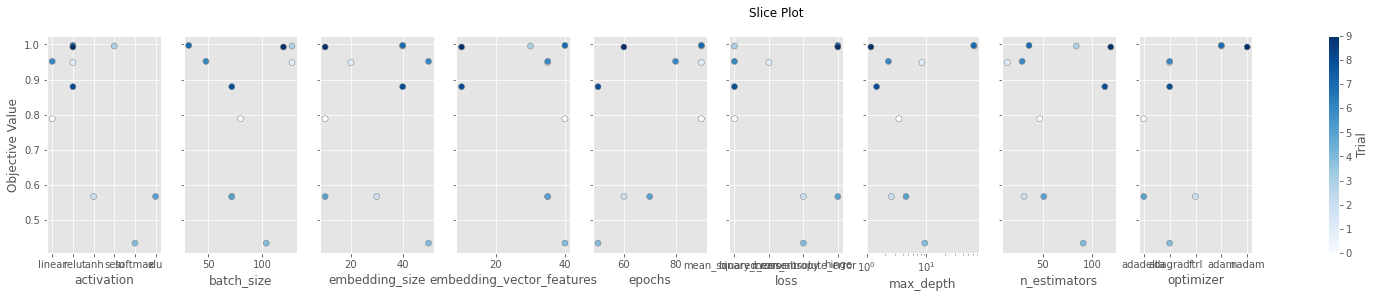

In [ ]:
fig = optuna.visualization.matplotlib.plot_slice(study_lstm)

In [ ]:
optuna.visualization.plot_contour(study_lstm, params=['n_estimators', 'max_depth', 'embedding_size', 'batch_size', 'embedding_vector_features', 'epochs', 'activation', 'loss', 'optimizer'])

In [ ]:
optuna.visualization.plot_edf(study_lstm)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study_lstm)

In [ ]:
def objective_gru(trial):

    # Parameters
    n_estimators = trial.suggest_int('n_estimators', 1, 120)
    max_depth = int(trial.suggest_float('max_depth', 1, 64, log=True))
    EMBEDDING_SIZE = trial.suggest_int("embedding_size", 10, 50, step=10)

    BATCH_SIZE = trial.suggest_int("batch_size", 32, 128, step=8)
    EMBEDDING_VECTOR_FEATURES = trial.suggest_int("embedding_vector_features", 10, 50, step=5)
    EPOCHS = trial.suggest_int("epochs", 50, 100, step=10)
    ACT = trial.suggest_categorical("activation", ["sigmoid","relu","linear","tanh","softmax","elu","selu"])
    LOSS = trial.suggest_categorical("loss", ["binary_crossentropy","mean_squared_error", "mean_absolute_error", "hinge"])
    OPT = trial.suggest_categorical("optimizer", ["sgd","rmsprop", "adam", "adadelta", "adagrad", "adamax", "nadam", "ftrl"])

    model_7 = Sequential()
    model_7.add(Embedding(voc_size, EMBEDDING_VECTOR_FEATURES, input_length=sent_length))
    model_7.add(GRU(100))
    model_7.add(Dense(1, activation=ACT))
    model_7.compile(loss=LOSS, optimizer=OPT, metrics=['accuracy'])
    model_7.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=EPOCHS, batch_size=BATCH_SIZE)
    classes_x_7 = (model.predict(X_test) > 0.5).astype("int32")
    score_7 = accuracy_score(y_test,classes_x_7)  

    if trial.should_prune():
      raise optuna.exceptions.TrialPruned() 

    return score_7

study_gru = optuna.create_study(sampler = TPESampler(),pruner = SuccessiveHalvingPruner(),direction='maximize')
study_gru.optimize(objective_gru, n_trials=10)

trial_gru = study_gru.best_trial

print('Accuracy: {}'.format(trial_gru.value))
print("Best hyperparameters: {}".format(trial_gru.params)) 

[I 2023-01-17 22:28:38,441] A new study created in memory with name: no-name-6dd6df60-df7c-4996-8016-6a686ab31898


Epoch 1/70
187/187 [==============================] - 9s 36ms/step - loss: 0.1830 - accuracy: 0.8992 - val_loss: 0.0948 - val_accuracy: 0.9863
Epoch 2/70
187/187 [==============================] - 6s 34ms/step - loss: 0.0512 - accuracy: 0.9895 - val_loss: 0.0409 - val_accuracy: 0.9913
Epoch 3/70
187/187 [==============================] - 6s 33ms/step - loss: 0.0217 - accuracy: 0.9956 - val_loss: 0.0269 - val_accuracy: 0.9945
Epoch 4/70
187/187 [==============================] - 6s 34ms/step - loss: 0.0148 - accuracy: 0.9978 - val_loss: 0.0241 - val_accuracy: 0.9902
Epoch 5/70
187/187 [==============================] - 6s 34ms/step - loss: 0.0116 - accuracy: 0.9979 - val_loss: 0.0229 - val_accuracy: 0.9929
Epoch 6/70
187/187 [==============================] - 6s 34ms/step - loss: 0.0096 - accuracy: 0.9984 - val_loss: 0.0248 - val_accuracy: 0.9874
Epoch 7/70
187/187 [==============================] - 6s 34ms/step - loss: 0.0082 - accuracy: 0.9987 - val_loss: 0.0232 - val_accuracy: 0.9880

[I 2023-01-17 22:37:03,666] Trial 0 finished with value: 0.9764898851831602 and parameters: {'n_estimators': 34, 'max_depth': 5.357136268370497, 'embedding_size': 10, 'batch_size': 88, 'embedding_vector_features': 25, 'epochs': 70, 'activation': 'tanh', 'loss': 'mean_absolute_error', 'optimizer': 'adam'}. Best is trial 0 with value: 0.9764898851831602.


Epoch 1/80
258/258 [==============================] - 12s 36ms/step - loss: 0.3595 - accuracy: 0.8523 - val_loss: 0.1211 - val_accuracy: 0.9563
Epoch 2/80
258/258 [==============================] - 9s 33ms/step - loss: 0.0907 - accuracy: 0.9741 - val_loss: 0.0856 - val_accuracy: 0.9765
Epoch 3/80
258/258 [==============================] - 9s 34ms/step - loss: 0.0608 - accuracy: 0.9838 - val_loss: 0.0613 - val_accuracy: 0.9841
Epoch 4/80
258/258 [==============================] - 9s 34ms/step - loss: 0.0462 - accuracy: 0.9892 - val_loss: 0.0598 - val_accuracy: 0.9874
Epoch 5/80
258/258 [==============================] - 9s 33ms/step - loss: 0.0382 - accuracy: 0.9923 - val_loss: 0.0447 - val_accuracy: 0.9869
Epoch 6/80
258/258 [==============================] - 9s 34ms/step - loss: 0.0333 - accuracy: 0.9937 - val_loss: 0.0413 - val_accuracy: 0.9885
Epoch 7/80
258/258 [==============================] - 9s 34ms/step - loss: 0.0289 - accuracy: 0.9950 - val_loss: 0.0424 - val_accuracy: 0.990

[I 2023-01-17 22:49:29,311] Trial 1 finished with value: 0.9907053034445052 and parameters: {'n_estimators': 109, 'max_depth': 39.421317948561416, 'embedding_size': 30, 'batch_size': 64, 'embedding_vector_features': 30, 'epochs': 80, 'activation': 'linear', 'loss': 'binary_crossentropy', 'optimizer': 'adamax'}. Best is trial 1 with value: 0.9907053034445052.


Epoch 1/70
229/229 [==============================] - 11s 39ms/step - loss: 0.1597 - accuracy: 0.9354 - val_loss: 0.0851 - val_accuracy: 0.9951
Epoch 2/70
229/229 [==============================] - 8s 36ms/step - loss: 0.0672 - accuracy: 0.9935 - val_loss: 0.0515 - val_accuracy: 0.9951
Epoch 3/70
229/229 [==============================] - 8s 36ms/step - loss: 0.0430 - accuracy: 0.9939 - val_loss: 0.0350 - val_accuracy: 0.9951
Epoch 4/70
229/229 [==============================] - 8s 36ms/step - loss: 0.0314 - accuracy: 0.9939 - val_loss: 0.0276 - val_accuracy: 0.9973
Epoch 5/70
229/229 [==============================] - 8s 37ms/step - loss: 0.0249 - accuracy: 0.9945 - val_loss: 0.0224 - val_accuracy: 0.9973
Epoch 6/70
229/229 [==============================] - 8s 37ms/step - loss: 0.0204 - accuracy: 0.9950 - val_loss: 0.0210 - val_accuracy: 0.9973
Epoch 7/70
229/229 [==============================] - 8s 37ms/step - loss: 0.0203 - accuracy: 0.9951 - val_loss: 0.0210 - val_accuracy: 0.997

[I 2023-01-17 22:59:54,866] Trial 2 finished with value: 0.9983597594313832 and parameters: {'n_estimators': 110, 'max_depth': 54.59314900438801, 'embedding_size': 10, 'batch_size': 72, 'embedding_vector_features': 40, 'epochs': 70, 'activation': 'linear', 'loss': 'mean_absolute_error', 'optimizer': 'adam'}. Best is trial 2 with value: 0.9983597594313832.


Epoch 1/50
147/147 [==============================] - 9s 46ms/step - loss: 0.7625 - accuracy: 0.8329 - val_loss: 0.6117 - val_accuracy: 0.9601
Epoch 2/50
147/147 [==============================] - 6s 41ms/step - loss: 0.5908 - accuracy: 0.9810 - val_loss: 0.5916 - val_accuracy: 0.9776
Epoch 3/50
147/147 [==============================] - 6s 41ms/step - loss: 0.5785 - accuracy: 0.9906 - val_loss: 0.5848 - val_accuracy: 0.9858
Epoch 4/50
147/147 [==============================] - 6s 41ms/step - loss: 0.5741 - accuracy: 0.9939 - val_loss: 0.5808 - val_accuracy: 0.9891
Epoch 5/50
147/147 [==============================] - 6s 41ms/step - loss: 0.5722 - accuracy: 0.9957 - val_loss: 0.5790 - val_accuracy: 0.9896
Epoch 6/50
147/147 [==============================] - 6s 41ms/step - loss: 0.5704 - accuracy: 0.9968 - val_loss: 0.5788 - val_accuracy: 0.9891
Epoch 7/50
147/147 [==============================] - 6s 41ms/step - loss: 0.5698 - accuracy: 0.9971 - val_loss: 0.5782 - val_accuracy: 0.9891

[I 2023-01-17 23:05:22,160] Trial 3 finished with value: 0.9890650628758885 and parameters: {'n_estimators': 32, 'max_depth': 3.7706261899002307, 'embedding_size': 30, 'batch_size': 112, 'embedding_vector_features': 25, 'epochs': 50, 'activation': 'sigmoid', 'loss': 'hinge', 'optimizer': 'adam'}. Best is trial 2 with value: 0.9983597594313832.


Epoch 1/80
159/159 [==============================] - 9s 42ms/step - loss: 0.8859 - accuracy: 0.7182 - val_loss: 0.7362 - val_accuracy: 0.8513
Epoch 2/80
159/159 [==============================] - 6s 38ms/step - loss: 0.6635 - accuracy: 0.9181 - val_loss: 0.6467 - val_accuracy: 0.9256
Epoch 3/80
159/159 [==============================] - 6s 38ms/step - loss: 0.6217 - accuracy: 0.9517 - val_loss: 0.6270 - val_accuracy: 0.9415
Epoch 4/80
159/159 [==============================] - 6s 39ms/step - loss: 0.6091 - accuracy: 0.9632 - val_loss: 0.6291 - val_accuracy: 0.9459
Epoch 5/80
159/159 [==============================] - 6s 38ms/step - loss: 0.6005 - accuracy: 0.9724 - val_loss: 0.6144 - val_accuracy: 0.9579
Epoch 6/80
159/159 [==============================] - 6s 38ms/step - loss: 0.5948 - accuracy: 0.9756 - val_loss: 0.6097 - val_accuracy: 0.9595
Epoch 7/80
159/159 [==============================] - 6s 38ms/step - loss: 0.5907 - accuracy: 0.9805 - val_loss: 0.6074 - val_accuracy: 0.9628

[I 2023-01-17 23:13:47,516] Trial 4 finished with value: 0.9830508474576272 and parameters: {'n_estimators': 55, 'max_depth': 8.625298353535447, 'embedding_size': 20, 'batch_size': 104, 'embedding_vector_features': 15, 'epochs': 80, 'activation': 'sigmoid', 'loss': 'hinge', 'optimizer': 'adamax'}. Best is trial 2 with value: 0.9983597594313832.


Epoch 1/80
206/206 [==============================] - 10s 39ms/step - loss: 8.5999 - accuracy: 0.4355 - val_loss: 8.6376 - val_accuracy: 0.4336
Epoch 2/80
206/206 [==============================] - 8s 37ms/step - loss: 8.6412 - accuracy: 0.4333 - val_loss: 8.6376 - val_accuracy: 0.4336
Epoch 3/80
206/206 [==============================] - 8s 37ms/step - loss: 8.6412 - accuracy: 0.4333 - val_loss: 8.6376 - val_accuracy: 0.4336
Epoch 4/80
206/206 [==============================] - 8s 37ms/step - loss: 8.6412 - accuracy: 0.4333 - val_loss: 8.6376 - val_accuracy: 0.4336
Epoch 5/80
206/206 [==============================] - 8s 37ms/step - loss: 8.6412 - accuracy: 0.4333 - val_loss: 8.6376 - val_accuracy: 0.4336
Epoch 6/80
206/206 [==============================] - 8s 36ms/step - loss: 8.6412 - accuracy: 0.4333 - val_loss: 8.6376 - val_accuracy: 0.4336
Epoch 7/80
206/206 [==============================] - 8s 36ms/step - loss: 8.6412 - accuracy: 0.4333 - val_loss: 8.6376 - val_accuracy: 0.433

[I 2023-01-17 23:24:12,655] Trial 5 finished with value: 0.4335702569710224 and parameters: {'n_estimators': 83, 'max_depth': 8.281830049159227, 'embedding_size': 40, 'batch_size': 80, 'embedding_vector_features': 35, 'epochs': 80, 'activation': 'relu', 'loss': 'binary_crossentropy', 'optimizer': 'sgd'}. Best is trial 2 with value: 0.9983597594313832.


Epoch 1/50
129/129 [==============================] - 8s 46ms/step - loss: 0.1567 - accuracy: 0.7642 - val_loss: 0.0711 - val_accuracy: 0.9262
Epoch 2/50
129/129 [==============================] - 5s 42ms/step - loss: 0.0431 - accuracy: 0.9472 - val_loss: 0.0374 - val_accuracy: 0.9519
Epoch 3/50
129/129 [==============================] - 6s 43ms/step - loss: 0.0249 - accuracy: 0.9703 - val_loss: 0.0277 - val_accuracy: 0.9656
Epoch 4/50
129/129 [==============================] - 8s 65ms/step - loss: 0.0172 - accuracy: 0.9801 - val_loss: 0.0236 - val_accuracy: 0.9738
Epoch 5/50
129/129 [==============================] - 5s 42ms/step - loss: 0.0132 - accuracy: 0.9855 - val_loss: 0.0195 - val_accuracy: 0.9754
Epoch 6/50
129/129 [==============================] - 5s 42ms/step - loss: 0.0098 - accuracy: 0.9889 - val_loss: 0.0183 - val_accuracy: 0.9770
Epoch 7/50
129/129 [==============================] - 5s 42ms/step - loss: 0.0076 - accuracy: 0.9923 - val_loss: 0.0161 - val_accuracy: 0.9798

[I 2023-01-17 23:29:38,144] Trial 6 finished with value: 0.9786768726079825 and parameters: {'n_estimators': 37, 'max_depth': 16.32413082232115, 'embedding_size': 20, 'batch_size': 128, 'embedding_vector_features': 15, 'epochs': 50, 'activation': 'sigmoid', 'loss': 'mean_squared_error', 'optimizer': 'adamax'}. Best is trial 2 with value: 0.9983597594313832.


Epoch 1/50
172/172 [==============================] - 10s 43ms/step - loss: 0.0860 - accuracy: 0.8754 - val_loss: 0.0171 - val_accuracy: 0.9831
Epoch 2/50
172/172 [==============================] - 7s 40ms/step - loss: 0.0111 - accuracy: 0.9873 - val_loss: 0.0083 - val_accuracy: 0.9923
Epoch 3/50
172/172 [==============================] - 9s 54ms/step - loss: 0.0056 - accuracy: 0.9942 - val_loss: 0.0055 - val_accuracy: 0.9945
Epoch 4/50
172/172 [==============================] - 8s 44ms/step - loss: 0.0035 - accuracy: 0.9964 - val_loss: 0.0056 - val_accuracy: 0.9940
Epoch 5/50
172/172 [==============================] - 7s 41ms/step - loss: 0.0025 - accuracy: 0.9975 - val_loss: 0.0051 - val_accuracy: 0.9951
Epoch 6/50
172/172 [==============================] - 7s 41ms/step - loss: 0.0019 - accuracy: 0.9982 - val_loss: 0.0052 - val_accuracy: 0.9940
Epoch 7/50
172/172 [==============================] - 7s 41ms/step - loss: 0.0014 - accuracy: 0.9987 - val_loss: 0.0064 - val_accuracy: 0.992

[I 2023-01-17 23:36:03,258] Trial 7 finished with value: 0.9928922908693275 and parameters: {'n_estimators': 70, 'max_depth': 22.40901571387122, 'embedding_size': 50, 'batch_size': 96, 'embedding_vector_features': 50, 'epochs': 50, 'activation': 'sigmoid', 'loss': 'mean_squared_error', 'optimizer': 'rmsprop'}. Best is trial 2 with value: 0.9983597594313832.


Epoch 1/70
129/129 [==============================] - 9s 46ms/step - loss: 1.5172 - accuracy: 0.5667 - val_loss: 1.3289 - val_accuracy: 0.5664
Epoch 2/70
129/129 [==============================] - 5s 41ms/step - loss: 1.2419 - accuracy: 0.5667 - val_loss: 1.1687 - val_accuracy: 0.5664
Epoch 3/70
129/129 [==============================] - 5s 41ms/step - loss: 1.1128 - accuracy: 0.5667 - val_loss: 1.0624 - val_accuracy: 0.5664
Epoch 4/70
129/129 [==============================] - 5s 41ms/step - loss: 1.0202 - accuracy: 0.5667 - val_loss: 0.9813 - val_accuracy: 0.5664
Epoch 5/70
129/129 [==============================] - 5s 41ms/step - loss: 0.9473 - accuracy: 0.5667 - val_loss: 0.9157 - val_accuracy: 0.5664
Epoch 6/70
129/129 [==============================] - 5s 41ms/step - loss: 0.8876 - accuracy: 0.5667 - val_loss: 0.8614 - val_accuracy: 0.5664
Epoch 7/70
129/129 [==============================] - 5s 42ms/step - loss: 0.8379 - accuracy: 0.5667 - val_loss: 0.8160 - val_accuracy: 0.5664

[I 2023-01-17 23:43:29,694] Trial 8 finished with value: 0.9196282121377802 and parameters: {'n_estimators': 86, 'max_depth': 12.405168948783166, 'embedding_size': 50, 'batch_size': 128, 'embedding_vector_features': 10, 'epochs': 70, 'activation': 'relu', 'loss': 'binary_crossentropy', 'optimizer': 'ftrl'}. Best is trial 2 with value: 0.9983597594313832.


Epoch 1/70
343/343 [==============================] - 10s 23ms/step - loss: 1.0599 - accuracy: 0.5628 - val_loss: 1.0525 - val_accuracy: 0.5664
Epoch 2/70
343/343 [==============================] - 7s 21ms/step - loss: 1.0462 - accuracy: 0.5667 - val_loss: 1.0397 - val_accuracy: 0.5664
Epoch 3/70
343/343 [==============================] - 7s 21ms/step - loss: 1.0344 - accuracy: 0.5667 - val_loss: 1.0291 - val_accuracy: 0.5664
Epoch 4/70
343/343 [==============================] - 7s 21ms/step - loss: 1.0251 - accuracy: 0.5667 - val_loss: 1.0211 - val_accuracy: 0.5664
Epoch 5/70
343/343 [==============================] - 7s 21ms/step - loss: 1.0182 - accuracy: 0.5667 - val_loss: 1.0154 - val_accuracy: 0.5664
Epoch 6/70
343/343 [==============================] - 7s 21ms/step - loss: 1.0134 - accuracy: 0.5667 - val_loss: 1.0114 - val_accuracy: 0.5664
Epoch 7/70
343/343 [==============================] - 9s 26ms/step - loss: 1.0100 - accuracy: 0.5667 - val_loss: 1.0087 - val_accuracy: 0.566

[I 2023-01-17 23:52:55,099] Trial 9 finished with value: 0.5664297430289775 and parameters: {'n_estimators': 19, 'max_depth': 29.09931124962797, 'embedding_size': 50, 'batch_size': 48, 'embedding_vector_features': 40, 'epochs': 70, 'activation': 'sigmoid', 'loss': 'hinge', 'optimizer': 'sgd'}. Best is trial 2 with value: 0.9983597594313832.


Accuracy: 0.9983597594313832
Best hyperparameters: {'n_estimators': 110, 'max_depth': 54.59314900438801, 'embedding_size': 10, 'batch_size': 72, 'embedding_vector_features': 40, 'epochs': 70, 'activation': 'linear', 'loss': 'mean_absolute_error', 'optimizer': 'adam'}


In [ ]:
optuna.visualization.plot_optimization_history(study_gru)

<ipython-input-138-5e7e39ab8985>:1: ExperimentalWarning:

plot_slice is experimental (supported from v2.2.0). The interface can change in the future.



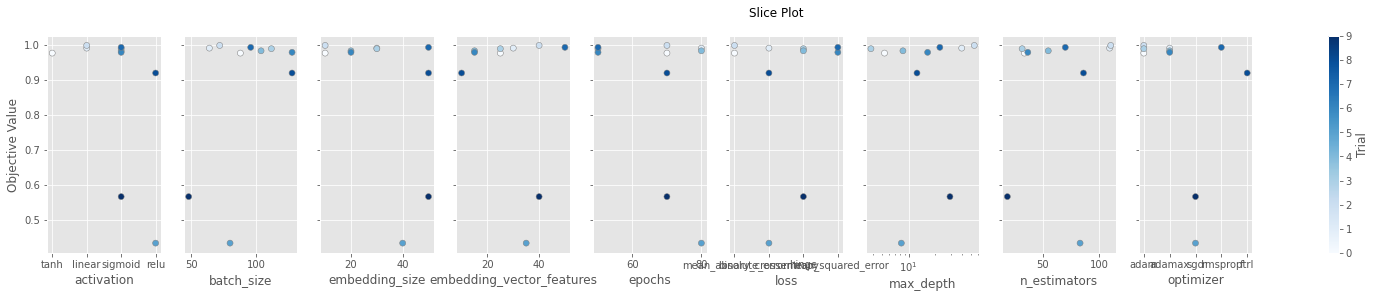

In [ ]:
fig = optuna.visualization.matplotlib.plot_slice(study_gru)

In [ ]:
optuna.visualization.plot_contour(study_gru, params=['n_estimators', 'max_depth', 'embedding_size', 'batch_size', 'embedding_vector_features', 'epochs', 'activation', 'loss', 'optimizer'])

In [ ]:
optuna.visualization.plot_edf(study_gru)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study_gru)

In [ ]:
def objective_lr(trial):

  # Parameters
  n_estimators = trial.suggest_int('n_estimators', 1, 120)
  max_depth = int(trial.suggest_float('max_depth', 1, 64, log=True))
  EMBEDDING_SIZE = trial.suggest_int("embedding_size", 10, 50, step=10)
  MAX_ITER = trial.suggest_int("max_iter", 100, 1200, step=100)

  model_1 = LogisticRegression(max_iter=MAX_ITER)
  model_1.fit(X_train,y_train)
  pred_1 = model_1.predict(X_test)
  score_1 = accuracy_score(y_test,pred_1)

  if trial.should_prune():
    raise optuna.exceptions.TrialPruned()

  return score_1

study_lr = optuna.create_study(sampler = TPESampler(),pruner = SuccessiveHalvingPruner(),direction='maximize')
study_lr.optimize(objective_lr, n_trials=100)

trial_lr = study_lr.best_trial

print('Accuracy: {}'.format(trial_lr.value))
print("Best hyperparameters: {}".format(trial_lr.params))

[I 2023-01-17 19:51:26,539] A new study created in memory with name: no-name-22550fd5-f5fd-49ee-98f4-bb46672cf737
[I 2023-01-17 19:51:26,749] Trial 0 finished with value: 0.7397484964461455 and parameters: {'n_estimators': 63, 'max_depth': 2.4160837584328103, 'embedding_size': 50, 'max_iter': 700}. Best is trial 0 with value: 0.7397484964461455.
[I 2023-01-17 19:51:26,953] Trial 1 finished with value: 0.7397484964461455 and parameters: {'n_estimators': 78, 'max_depth': 63.22302495399621, 'embedding_size': 10, 'max_iter': 200}. Best is trial 0 with value: 0.7397484964461455.
[I 2023-01-17 19:51:27,165] Trial 2 finished with value: 0.7397484964461455 and parameters: {'n_estimators': 49, 'max_depth': 3.3339158304592305, 'embedding_size': 50, 'max_iter': 500}. Best is trial 0 with value: 0.7397484964461455.
[I 2023-01-17 19:51:27,392] Trial 3 finished with value: 0.7397484964461455 and parameters: {'n_estimators': 35, 'max_depth': 1.400305991069782, 'embedding_size': 10, 'max_iter': 200}. 

Accuracy: 0.7397484964461455
Best hyperparameters: {'n_estimators': 63, 'max_depth': 2.4160837584328103, 'embedding_size': 50, 'max_iter': 700}


In [ ]:
optuna.visualization.plot_contour(study_lr, params=['n_estimators', 'max_depth', 'max_iter'])

In [ ]:
optuna.visualization.plot_parallel_coordinate(study_lr)

In [ ]:
def objective_mnb(trial):

  # Parameters
  n_estimators = trial.suggest_int('n_estimators', 1, 120)
  max_depth = int(trial.suggest_float('max_depth', 1, 64, log=True))
  EMBEDDING_SIZE = trial.suggest_int("embedding_size", 10, 50, step=10)

  model_2 = MultinomialNB()
  model_2.fit(X_train,y_train)
  pred_2 = model_2.predict(X_test)
  score_2 = accuracy_score(y_test,pred_2)

  if trial.should_prune():
    raise optuna.exceptions.TrialPruned()

  return score_2

study_mnb = optuna.create_study(sampler = TPESampler(),pruner = SuccessiveHalvingPruner(),direction='maximize')
study_mnb.optimize(objective_mnb, n_trials=100)

trial_mnb = study_mnb.best_trial

print('Accuracy: {}'.format(trial_mnb.value))
print("Best hyperparameters: {}".format(trial_mnb.params))

[I 2023-01-17 19:57:22,698] A new study created in memory with name: no-name-57fc662e-0570-4e5c-b871-ce4bf28600c4
[I 2023-01-17 19:57:22,717] Trial 0 finished with value: 0.6872607982504101 and parameters: {'n_estimators': 69, 'max_depth': 1.2508472855178425, 'embedding_size': 30}. Best is trial 0 with value: 0.6872607982504101.
[I 2023-01-17 19:57:22,730] Trial 1 finished with value: 0.6872607982504101 and parameters: {'n_estimators': 93, 'max_depth': 2.4412978865351964, 'embedding_size': 40}. Best is trial 0 with value: 0.6872607982504101.
[I 2023-01-17 19:57:22,754] Trial 2 finished with value: 0.6872607982504101 and parameters: {'n_estimators': 28, 'max_depth': 45.9966631702964, 'embedding_size': 20}. Best is trial 0 with value: 0.6872607982504101.
[I 2023-01-17 19:57:22,769] Trial 3 finished with value: 0.6872607982504101 and parameters: {'n_estimators': 26, 'max_depth': 4.260251255567474, 'embedding_size': 50}. Best is trial 0 with value: 0.6872607982504101.
[I 2023-01-17 19:57:2

Accuracy: 0.6872607982504101
Best hyperparameters: {'n_estimators': 69, 'max_depth': 1.2508472855178425, 'embedding_size': 30}


In [ ]:
optuna.visualization.plot_contour(study_mnb, params=['n_estimators', 'max_depth'])

In [ ]:
optuna.visualization.plot_parallel_coordinate(study_mnb)

In [ ]:
def objective_dtc(trial):

  # Parameters
  n_estimators = trial.suggest_int('n_estimators', 1, 120)
  max_depth = int(trial.suggest_float('max_depth', 1, 64, log=True))
  EMBEDDING_SIZE = trial.suggest_int("embedding_size", 10, 50, step=10)

  model_3 = DecisionTreeClassifier()
  model_3.fit(X_train,y_train)
  pred_3 = model_3.predict(X_test)
  score_3 = accuracy_score(y_test,pred_3)

  if trial.should_prune():
    raise optuna.exceptions.TrialPruned()

  return score_3

study_dtc = optuna.create_study(sampler = TPESampler(),pruner = SuccessiveHalvingPruner(),direction='maximize')
study_dtc.optimize(objective_dtc, n_trials=100)

trial_dtc = study_dtc.best_trial

print('Accuracy: {}'.format(trial_dtc.value))
print("Best hyperparameters: {}".format(trial_dtc.params))

[I 2023-01-17 19:59:40,734] A new study created in memory with name: no-name-3d916c79-8429-4bb2-9815-17a678c08c99
[I 2023-01-17 19:59:40,932] Trial 0 finished with value: 0.9201749589939858 and parameters: {'n_estimators': 81, 'max_depth': 16.46703670819206, 'embedding_size': 40}. Best is trial 0 with value: 0.9201749589939858.
[I 2023-01-17 19:59:41,132] Trial 1 finished with value: 0.9201749589939858 and parameters: {'n_estimators': 50, 'max_depth': 33.54974809293667, 'embedding_size': 30}. Best is trial 0 with value: 0.9201749589939858.
[I 2023-01-17 19:59:41,325] Trial 2 finished with value: 0.9212684527063969 and parameters: {'n_estimators': 77, 'max_depth': 25.370542282180377, 'embedding_size': 30}. Best is trial 2 with value: 0.9212684527063969.
[I 2023-01-17 19:59:41,520] Trial 3 finished with value: 0.9212684527063969 and parameters: {'n_estimators': 115, 'max_depth': 20.906043947278974, 'embedding_size': 20}. Best is trial 2 with value: 0.9212684527063969.
[I 2023-01-17 19:59

Accuracy: 0.928922908693275
Best hyperparameters: {'n_estimators': 95, 'max_depth': 46.012373295113335, 'embedding_size': 50}


In [ ]:
optuna.visualization.plot_contour(study_dtc, params=['n_estimators', 'max_depth'])

In [ ]:
optuna.visualization.plot_parallel_coordinate(study_dtc)

In [ ]:
def objective_rfc(trial):

  # Parameters
  n_estimators = trial.suggest_int('n_estimators', 1, 120)
  max_depth = int(trial.suggest_float('max_depth', 1, 64, log=True))
  EMBEDDING_SIZE = trial.suggest_int("embedding_size", 10, 50, step=10)

  model_4 = RandomForestClassifier()
  model_4.fit(X_train,y_train)
  pred_4 = model_4.predict(X_test)
  score_4 = accuracy_score(y_test,pred_4)

  if trial.should_prune():
    raise optuna.exceptions.TrialPruned()

  return score_4

study_rfc = optuna.create_study(sampler = TPESampler(),pruner = SuccessiveHalvingPruner(),direction='maximize')
study_rfc.optimize(objective_rfc, n_trials=100)

trial_rfc = study_rfc.best_trial

print('Accuracy: {}'.format(trial_rfc.value))
print("Best hyperparameters: {}".format(trial_rfc.params))

[I 2023-01-17 20:01:24,823] A new study created in memory with name: no-name-813fcce6-6567-4418-b753-7c68db0a6049
[I 2023-01-17 20:01:28,279] Trial 0 finished with value: 0.9152542372881356 and parameters: {'n_estimators': 62, 'max_depth': 2.777821758972285, 'embedding_size': 10}. Best is trial 0 with value: 0.9152542372881356.
[I 2023-01-17 20:01:31,607] Trial 1 finished with value: 0.9136139967195188 and parameters: {'n_estimators': 58, 'max_depth': 2.8722507398759727, 'embedding_size': 20}. Best is trial 0 with value: 0.9152542372881356.
[I 2023-01-17 20:01:34,932] Trial 2 finished with value: 0.9158009841443412 and parameters: {'n_estimators': 116, 'max_depth': 3.9437169686636495, 'embedding_size': 20}. Best is trial 2 with value: 0.9158009841443412.
[I 2023-01-17 20:01:38,247] Trial 3 finished with value: 0.9125205030071077 and parameters: {'n_estimators': 100, 'max_depth': 5.323916571420925, 'embedding_size': 30}. Best is trial 2 with value: 0.9158009841443412.
[I 2023-01-17 20:0

Accuracy: 0.9207217058501913
Best hyperparameters: {'n_estimators': 86, 'max_depth': 6.242246099106709, 'embedding_size': 50}


In [ ]:
optuna.visualization.plot_contour(study_rfc, params=['n_estimators', 'max_depth'])

In [ ]:
optuna.visualization.plot_parallel_coordinate(study_rfc)

In [ ]:
def objective_xgb(trial):

  # Parameters
  n_estimators = trial.suggest_int('n_estimators', 1, 120)
  max_depth = int(trial.suggest_float('max_depth', 1, 64, log=True))
  EMBEDDING_SIZE = trial.suggest_int("embedding_size", 10, 50, step=10)
  
  model_5 = XGBClassifier()
  model_5.fit(X_train,y_train)
  pred_5 = model_5.predict(X_test)
  score_5 = accuracy_score(y_test,pred_5)

  if trial.should_prune():
    raise optuna.exceptions.TrialPruned()

  return score_5


study_xgb = optuna.create_study(sampler = TPESampler(),pruner = SuccessiveHalvingPruner(),direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=100)

trial_xgb = study_xgb.best_trial

print('Accuracy: {}'.format(trial_xgb.value))
print("Best hyperparameters: {}".format(trial_xgb.params))

[I 2023-01-17 20:08:30,273] A new study created in memory with name: no-name-563e2c61-27e6-41ee-803b-387817505c61
[I 2023-01-17 20:08:31,772] Trial 0 finished with value: 0.9158009841443412 and parameters: {'n_estimators': 105, 'max_depth': 24.528713699576628, 'embedding_size': 50}. Best is trial 0 with value: 0.9158009841443412.
[I 2023-01-17 20:08:33,285] Trial 1 finished with value: 0.9158009841443412 and parameters: {'n_estimators': 37, 'max_depth': 3.1273245459200325, 'embedding_size': 30}. Best is trial 0 with value: 0.9158009841443412.
[I 2023-01-17 20:08:34,764] Trial 2 finished with value: 0.9158009841443412 and parameters: {'n_estimators': 7, 'max_depth': 6.072179284371705, 'embedding_size': 20}. Best is trial 0 with value: 0.9158009841443412.
[I 2023-01-17 20:08:36,243] Trial 3 finished with value: 0.9158009841443412 and parameters: {'n_estimators': 100, 'max_depth': 7.207245481291217, 'embedding_size': 10}. Best is trial 0 with value: 0.9158009841443412.
[I 2023-01-17 20:08

Accuracy: 0.9158009841443412
Best hyperparameters: {'n_estimators': 105, 'max_depth': 24.528713699576628, 'embedding_size': 50}


In [ ]:
optuna.visualization.plot_contour(study_xgb, params=['n_estimators', 'max_depth'])

In [ ]:
optuna.visualization.plot_parallel_coordinate(study_xgb)

In [ ]:
def objective_cbc(trial):

  # Parameters
  n_estimators = trial.suggest_int('n_estimators', 1, 120)
  max_depth = int(trial.suggest_float('max_depth', 1, 64, log=True))
  EMBEDDING_SIZE = trial.suggest_int("embedding_size", 10, 50, step=10)

  model_6 = CatBoostClassifier(iterations=300)
  model_6.fit(X_train,y_train)
  pred_6 = model_6.predict(X_test)
  score_6 = accuracy_score(y_test,pred_6)

  if trial.should_prune():
    raise optuna.exceptions.TrialPruned()

  return score_6


study_cbc = optuna.create_study(sampler = TPESampler(),pruner = SuccessiveHalvingPruner(),direction='maximize')
study_cbc.optimize(objective_xgb, n_trials=100)

trial_cbc = study_xgb.best_trial

print('Accuracy: {}'.format(trial_cbc.value))
print("Best hyperparameters: {}".format(trial_cbc.params))

[I 2023-01-17 20:23:03,738] A new study created in memory with name: no-name-3009ba36-bf6b-44c3-a10a-be1d1a72d2b6
[I 2023-01-17 20:23:05,300] Trial 0 finished with value: 0.9158009841443412 and parameters: {'n_estimators': 106, 'max_depth': 37.738831268331076, 'embedding_size': 30}. Best is trial 0 with value: 0.9158009841443412.
[I 2023-01-17 20:23:06,811] Trial 1 finished with value: 0.9158009841443412 and parameters: {'n_estimators': 114, 'max_depth': 16.77325148248294, 'embedding_size': 20}. Best is trial 0 with value: 0.9158009841443412.
[I 2023-01-17 20:23:08,310] Trial 2 finished with value: 0.9158009841443412 and parameters: {'n_estimators': 58, 'max_depth': 23.967017051365676, 'embedding_size': 20}. Best is trial 0 with value: 0.9158009841443412.
[I 2023-01-17 20:23:09,808] Trial 3 finished with value: 0.9158009841443412 and parameters: {'n_estimators': 4, 'max_depth': 2.299218285951838, 'embedding_size': 20}. Best is trial 0 with value: 0.9158009841443412.
[I 2023-01-17 20:23

Accuracy: 0.9158009841443412
Best hyperparameters: {'n_estimators': 105, 'max_depth': 24.528713699576628, 'embedding_size': 50}


In [ ]:
optuna.visualization.plot_contour(study_cbc, params=['n_estimators', 'max_depth'])

In [ ]:
optuna.visualization.plot_parallel_coordinate(study_cbc)